In [1]:
import numpy as np

# Inputs

CELL_DENS = 400     # [cpsi]
T_WALL = 6          # [mils]
WASHCOAT = 120      # [g/l]
DIAM = 130          # [mm]
LENGTH = 70         # [mm]
m_exh = 5e-2        # [kg/s]


# Geometry parameters
in2m = 25.4e-3                  # [m/in]    inch to meter conversion
cpsm = CELL_DENS / (in2m**2)    # cell density metric
s = T_WALL * in2m / 1e3         # wall thickness [m]
w = WASHCOAT                    # Washcoat[g/l]
L = LENGTH / 1e3                # Length [m]
D = DIAM / 1e3                  # outer diameter [m]



# constant parameters
dens_wash = 1500                # density of washcoat [kg/m3]
dens_wall = 1500                # density of cordierite [kg/m3]
cp_wall = 1000                  # [J/kgK] Cordierite density
k_wall = 1.5                    # [W/mK] Cordierite conductivity
M_exh = 29                      # [g/mol] Molar mass of exhaust
Sh = 2.976                      # number Sherwood [-]
Nu = 2.976                      # number Nusselt [-]
E = 1e5                         # Activation energy [J/mol]
R_u = 8.314                       # Universal gas constant [J/(mol*K)]



# initializes empty tables
def init_arrays(matrix_size):
    variables = [
        'k_exh',  # thermal conductivity of gas
        'cp_exh',     # Heat capacity of gas
        'h',         # Conduction coefficient
        'NTU',       # number of transfer units
        'q_conv',     # thermal flow during convection
        'q_cond1',    # thermal flow during conduction 1
        'q_cond2',    # thermal flow during conduction 2
        'T_exh',      # Temperature of gas
        'T_wall',     # Wall Temperature
    ]

    for var in variables:
        globals()[var] = np.zeros(matrix_size)

# calculates dh and da
def calc_geom(cpsm):
    A_chan = 1 / cpsm           # Area of a channel (cross-section) [m^2]
    da = np.sqrt(A_chan)        # Outer diameter of a channel [m]
    di = da - s                 # Inner diameter of a channel [m]
    e = (di ** 2) / (da ** 2)   # Coating factor
    eprime = e - w / dens_wash
    dh = da * np.sqrt(eprime)   # Hydraulic diameter [m]

    return dh, da

# calculates swap surface [A_swap]
def calc_swap_surface(dh, length):
    P = 4 * dh                  # perimeter [m]
    swap_surf = P * length      # swap surface [m2]

    return swap_surf

# calculates wall mass
def calc_wall_mass(dh, da, dens_wall, length):
    A_w_cross = da ** 2 - dh ** 2                      # Wall cross section [m2]
    m_wall = A_w_cross * length * dens_wall              # Mass of wall [kg]

    return m_wall, A_w_cross

# calculates [m_dot_ch] and [num_channels]
def calc_m_channel(cpsm, D):
    num_channels = (np.pi / 4) * (D ** 2) * cpsm    # number of channels
    m_dot_ch = m_exh / num_channels                 # mass flow of gas in individual channel [kg/s]

    return m_dot_ch, num_channels


# V = (dh ** 2) * L * num_channels                # Catalyst volume [m3]


1. Calculation of transient temperature field

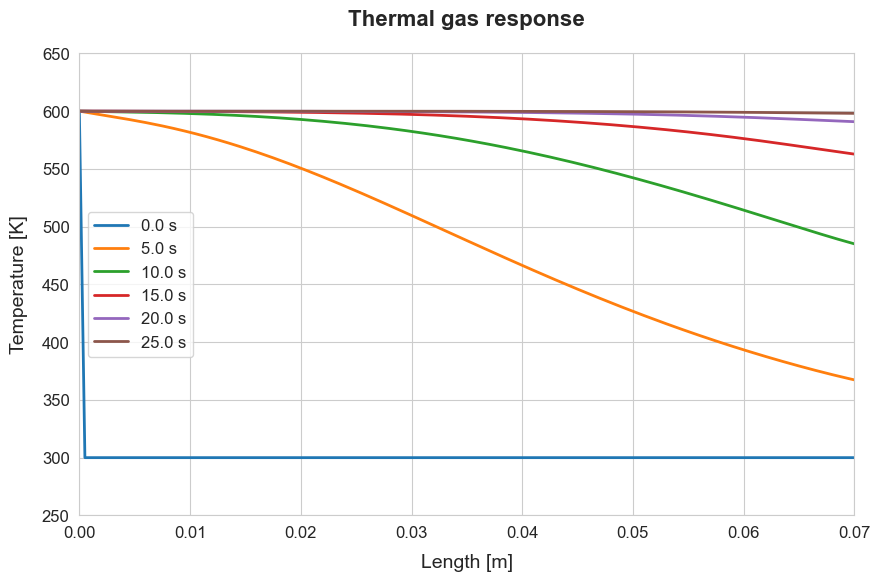

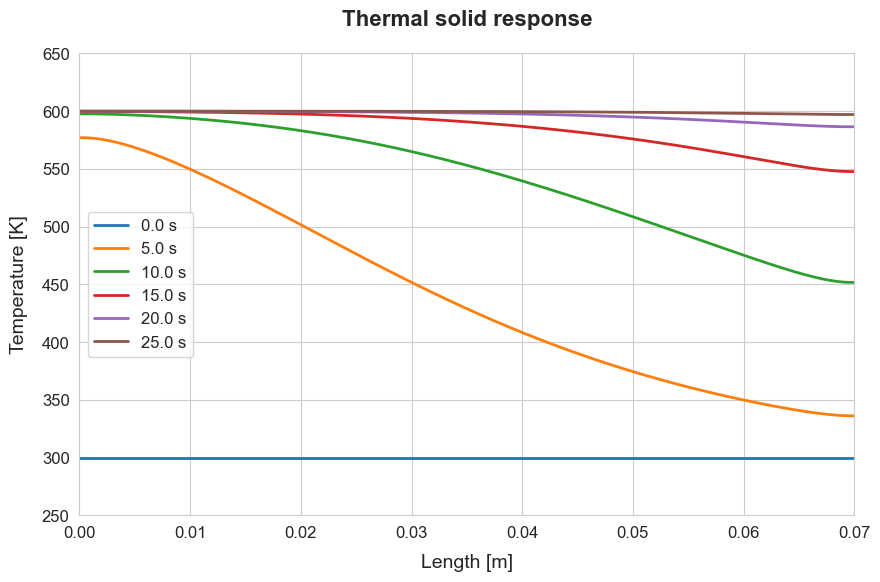

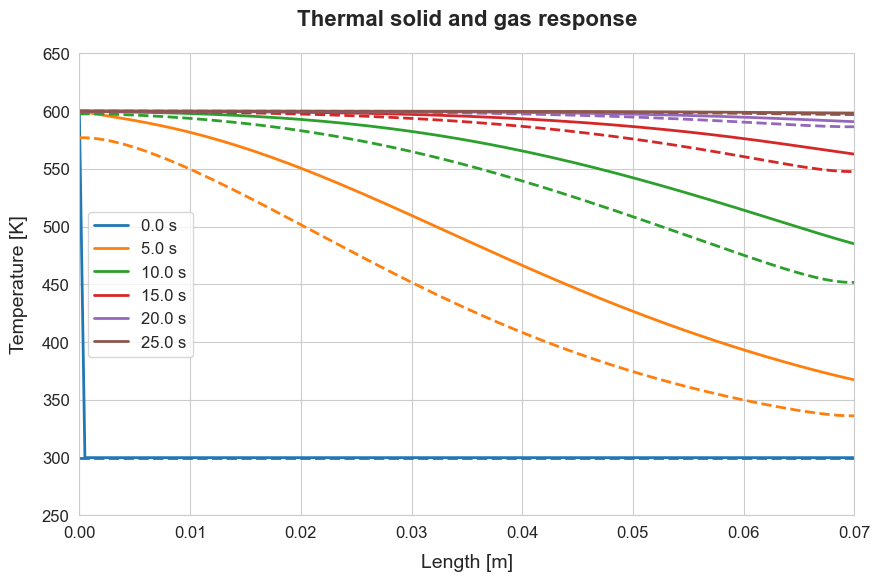

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Calculation of transient temperature range
T0 = 300  # Initial Temperature [K]
Tin = 600  # Inlet gas temperature [K]
dt = 0.01  # t_i [s]

num_nodes = 141             # Number of num_nodes
dL = L / (num_nodes - 1)   # length of node
L_arr = np.linspace(0, L, num_nodes)

tmax = 10000  # adequate rows for simulation
matrix_size = (tmax, num_nodes)
init_arrays(matrix_size)


# Initial and boundary conditions
T_exh[0, 1:] = np.ones(num_nodes - 1) * T0   # initial condition for first time interval
T_exh[:, 0] = np.ones(tmax) * Tin            # boundary condition for 1st node (has same temp as exhaust gas)
T_wall[0, :] = np.ones(num_nodes) * T0       # initial condition for first time interval (all nodes have T0 temp)

dh, da = calc_geom(cpsm)
m_dot_ch, num_channels = calc_m_channel(cpsm, D)
A_swap = calc_swap_surface(dh, dL)
dm_wall, A_w_cross = calc_wall_mass(dh, da, dens_wall, dL)

# MAIN LOOP
equilibrium = False
t_i = 1

while not equilibrium:
    
    for i in range(num_nodes):  # Spatial step
        k_exh[t_i, i] = 2.02e-4 * (T_exh[t_i - 1, i] ** 0.837)
        cp_exh[t_i, i] = 267 * (T_exh[t_i - 1, i] ** 0.226)
        h[t_i, i] = (Nu * k_exh[t_i, i]) / dh
        NTU[t_i, i] = h[t_i, i] * A_swap / (m_dot_ch * cp_exh[t_i, i])

    for i in range(1, num_nodes):
        T_exh[t_i, i] = T_wall[t_i - 1, i - 1] + (T_exh[t_i - 1, i - 1] - T_wall[t_i - 1, i - 1]) * np.exp(-NTU[t_i - 1, i - 1])

    for i in range(1, num_nodes - 1):
        q_conv[t_i, i] = h[t_i, i] * A_swap * (T_exh[t_i - 1, i] - T_wall[t_i - 1, i])
        q_cond1[t_i, i] = (k_wall * A_swap / dL) * (T_wall[t_i - 1, i - 1] - T_wall[t_i - 1, i])
        q_cond2[t_i, i] = (k_wall * A_swap / dL) * (T_wall[t_i - 1, i + 1] - T_wall[t_i - 1, i])
        T_wall[t_i, i] = T_wall[t_i - 1, i] + (q_conv[t_i, i] + q_cond1[t_i, i] + q_cond2[t_i, i]) * dt / (dm_wall * cp_wall)

    T_wall[t_i, 0] = T_wall[t_i, 1]  # Adiabatic start
    T_wall[t_i, -1] = T_wall[t_i, -2]  # Adiabatic end

    if np.all(np.abs(T_wall[t_i, :] - Tin) < Tin*0.002) and np.all(np.abs(T_exh[t_i, :] - Tin) < Tin*0.002):
        equilibrium = True

    t_i += 1

# Time when thermal equilibrium is reached
t_eq = (t_i - 1) * dt

# Plotting
time_interval = 5  # seconds
indices_to_plot = np.arange(0, t_i, int(time_interval / dt))


# Set the style
sns.set_style("whitegrid")

# Plot T_exh
plt.figure(figsize=(10, 6))
for idx in indices_to_plot:
    plt.plot(L_arr, T_exh[idx, :], label=f'{idx*dt:.1f} s', linewidth=2)
plt.title('Thermal gas response', fontsize=16, pad=20, fontweight='bold')
plt.xlabel('Length [m]', fontsize=14, labelpad=10)
plt.ylabel('Temperature [K]', fontsize=14, labelpad=10)
plt.legend(loc='best', fontsize=12)
plt.axis([0, L, 250, 650])
plt.tick_params(axis='both', which='major', labelsize=12)
plt.grid(True)

# Save the figure
plt.savefig('thermal_gas_response_plot.png', bbox_inches='tight')

# Show the plot
plt.show()

# Plot T_wall
plt.figure(figsize=(10, 6))
for idx in indices_to_plot:
    plt.plot(L_arr, T_wall[idx, :], label=f'{idx*dt:.1f} s', linewidth=2)
plt.title('Thermal solid response', fontsize=16, pad=20, fontweight='bold')
plt.xlabel('Length [m]', fontsize=14, labelpad=10)
plt.ylabel('Temperature [K]', fontsize=14, labelpad=10)
plt.legend(loc='best', fontsize=12)
plt.axis([0, L, 250, 650])
plt.tick_params(axis='both', which='major', labelsize=12)
plt.grid(True)

# Save the figure
plt.savefig('thermal_solid_response_plot.png', bbox_inches='tight')

# Show the plot
plt.show()

# Combined plot
plt.figure(figsize=(10, 6))
for idx in indices_to_plot:
    plt.plot(L_arr, T_exh[idx, :], label=f'{idx*dt:.1f} s', linestyle='-', linewidth=2)
    plt.plot(L_arr, T_wall[idx, :], label='_nolegend_', linestyle='--', color=plt.gca().lines[-1].get_color(), linewidth=2)
plt.title('Thermal solid and gas response', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Length [m]', fontsize=14, labelpad=10)
plt.ylabel('Temperature [K]', fontsize=14, labelpad=10)
plt.legend(loc='best', fontsize=12)
plt.axis([0, L, 250, 650])
plt.grid(True)
plt.tick_params(axis='both', which='major', labelsize=12)

# Save the figure
plt.savefig('thermal_solid_gas_response_plot.png', bbox_inches='tight')

# Show the plot
plt.show()



2. Calculation of mass transfer at “infinite” reaction rate conditions

    Length effect

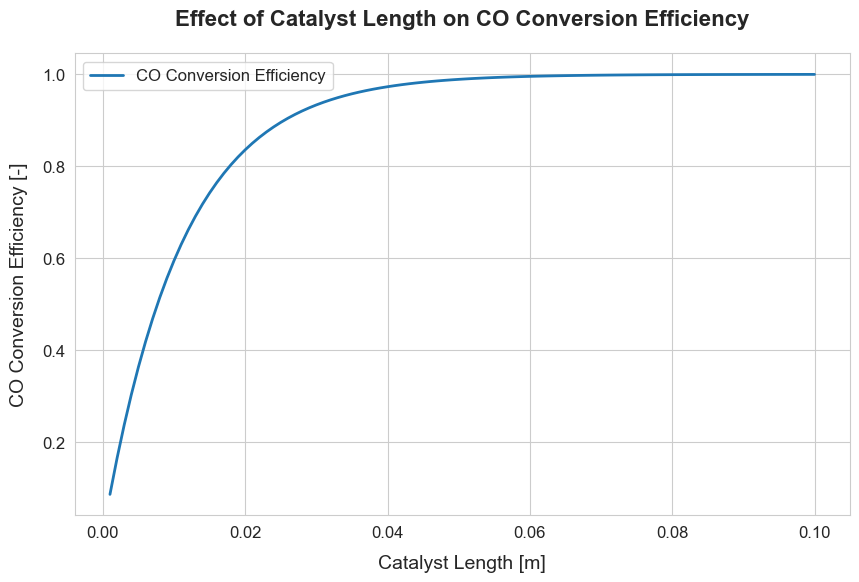

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Constants
T_cat = 900  # Temperature on catalytic area [K]

# Initialization
cat_lengths_arr = np.linspace(1e-3, 0.1, 100)
NTU_CO = np.zeros_like(cat_lengths_arr)
n_CO = np.zeros_like(cat_lengths_arr)

# Calculation
for i, cat_length in enumerate(cat_lengths_arr):

    A_swap_channel = calc_swap_surface(dh, cat_length)
    m_dot_ch, num_channels = calc_m_channel(cpsm, D)

    A_swap = A_swap_channel * num_channels  # Swap surface [m^2]

    dens_exh = 349.08 * T_cat**(-1.007)  # density of gas [Kg/m^3]

    DCO = 9.148e-10 * (T_cat ** 1.738)  # mass diffusion of CO [m^2/s]

    KmCO = Sh * DCO / dh  # Coeff mass transfer KmCO [m/s]

    NTU_CO[i] = A_swap * KmCO * dens_exh / m_exh  # NTU CO

    n_CO[i] = 1 - np.exp(-NTU_CO[i])  # Conversion rate of CO [-]


# Set the style
sns.set_style("whitegrid")

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(cat_lengths_arr, n_CO, label='CO Conversion Efficiency', linewidth=2)
plt.xlabel('Catalyst Length [m]', fontsize=14, labelpad=10)
plt.ylabel('CO Conversion Efficiency [-]', fontsize=14, labelpad=10)
plt.title('Effect of Catalyst Length on CO Conversion Efficiency', fontsize=16, pad=20, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True)
plt.tick_params(axis='both', which='major', labelsize=12)

# Save the figure
plt.savefig('catalyst_length_conversion_efficiency_plot.png', bbox_inches='tight')

# Show the plot
plt.show()

3. Calculation of efficiency as a function of temperature

    Temperature effect
    
    Mass flow rate effect

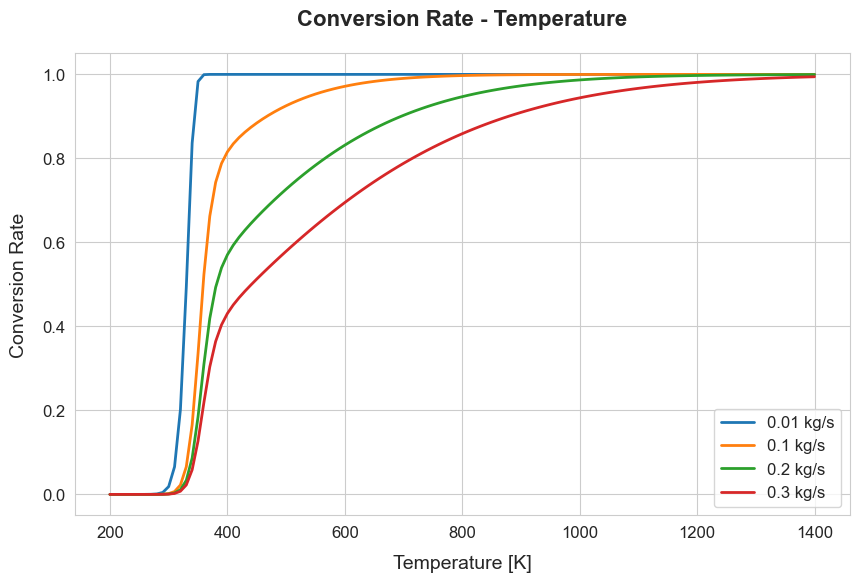

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Constants
num_nodes = 141             # Number of num_nodes
dL = L / (num_nodes - 1)   # length of node
L_arr = np.linspace(0, L, num_nodes)
V = (dh ** 2) * L * num_channels                # Catalyst volume [m3]

dh, da = calc_geom(cpsm)
dA_swap_channel = calc_swap_surface(dh, dL)  # Swap surface of node per channel [m^2]
A_swap_channel = calc_swap_surface(dh, L)
C_O2_in = 1e5  # O2 inlet concentration [ppm]
C_CO_in = 1e3  # CO inlet concentration [ppm]

# Conditions for A evaluation
Tin_eval = 400  # [K]
m_eval = 0.03  # [Kg/s]


# Initial conditions
dens_exh = 349.08 * Tin_eval**(-1.007)  # density [kg/m^3]
k_exh = 2.02e-4 * Tin_eval**0.837  # thermal conductivity of air [W/(m*K)]
D_CO = 9.148e-10 * Tin_eval**1.738  # mass diffusion of CO [m^2/s]
kc_CO = Sh * D_CO / dh  # mass transfer coeff kc_CO [m/s]
NTU_CO = A_swap_channel * num_channels * kc_CO * dens_exh / m_eval  # NTU CO [-]

# Estimation of A
n = 0.5  # Conversion rate
C_CO_out = C_CO_in - n * C_CO_in  # Concentration of CO at the exit [ppm]
Cs = (C_CO_out - (C_CO_in * np.exp(-NTU_CO))) / (1 - np.exp(-NTU_CO))  # Concentration at the interface [ppm]
nCO = (m_eval / (V * M_exh)) * (C_CO_in - C_CO_out) * (1 - np.exp(-NTU_CO))
A_arrh = nCO / (Cs * C_O2_in * np.exp(-E / (R_u * Tin_eval)))  # A Arrhenius

# Conversion Rate Calculation
timesteps = np.arange(200, 1401, 10)  # Temperature range from 200K to 1200K
massflow = [0.01, 0.1, 0.2, 0.3]  # Mass flow rates
ntot = np.zeros((len(massflow), len(timesteps)))

for i, m in enumerate(massflow):
    for t_index, Tin in enumerate(timesteps):
        D_CO = 9.148e-10 * Tin**1.738
        kc_CO = Sh * D_CO / dh
        NTU_CO = dA_swap_channel * kc_CO * dens_exh / (m / num_channels)
        Cgin = np.zeros(num_nodes)
        Cs = np.zeros(num_nodes)
        Cgout = np.zeros(num_nodes)
        
        Cgin[0] = 1000 / 1e6  # Initial CO concentration
        
        Cs[0] = (m / (V * M_exh)) * Cgin[0] * (np.exp(-NTU_CO) - 1) / ((m / (V * M_exh)) * (np.exp(-NTU_CO) - 1) - A_arrh * C_O2_in * np.exp(-E / (R_u * Tin)))
        Cgout[0] = Cs[0] + (Cgin[0] - Cs[0]) * np.exp(-NTU_CO)
        
        for nx in range(1, num_nodes):
            Cgin[nx] = Cgout[nx - 1]
            Cs[nx] = (m / (V * M_exh)) * Cgin[nx] * (np.exp(-NTU_CO) - 1) / ((m / (V * M_exh)) * (np.exp(-NTU_CO) - 1) - A_arrh * C_O2_in * np.exp(-E / (R_u * Tin)))
            Cgout[nx] = Cs[nx] + (Cgin[nx] - Cs[nx]) * np.exp(-NTU_CO)
        
        ntot[i, t_index] = 1 - (Cgout[-1] / Cgin[0])  # Conversion Rate

# Set the style
sns.set_style("whitegrid")

# Plotting the results
plt.figure(figsize=(10, 6))
for i, m in enumerate(massflow):
    plt.plot(timesteps, ntot[i], label=f'{m} kg/s', linewidth=2)
plt.title('Conversion Rate - Temperature', fontsize=16, pad=20, fontweight='bold')
plt.xlabel('Temperature [K]', fontsize=14, labelpad=10)
plt.ylabel('Conversion Rate', fontsize=14, labelpad=10)
plt.legend(loc='best', fontsize=12)
plt.grid(True)
plt.tick_params(axis='both', which='major', labelsize=12)

# Save the figure
plt.savefig('conversion_rate_temperature_plot.png', bbox_inches='tight')

# Show the plot
plt.show()


4. Combined calculation of heat transfer, mass transfer and chemical reactions at a driving cycle WLTC

C:\Users\theom\AppData\Local\Temp\ipykernel_26136\2853489512.py:170: RuntimeWarning: invalid value encountered in divide
  eta_CO = 1 - c_g_CO[:, -1] / CO_in


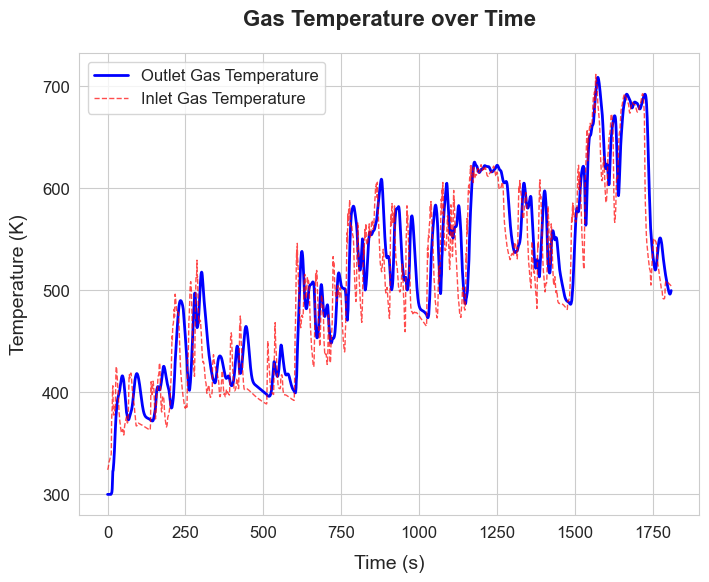

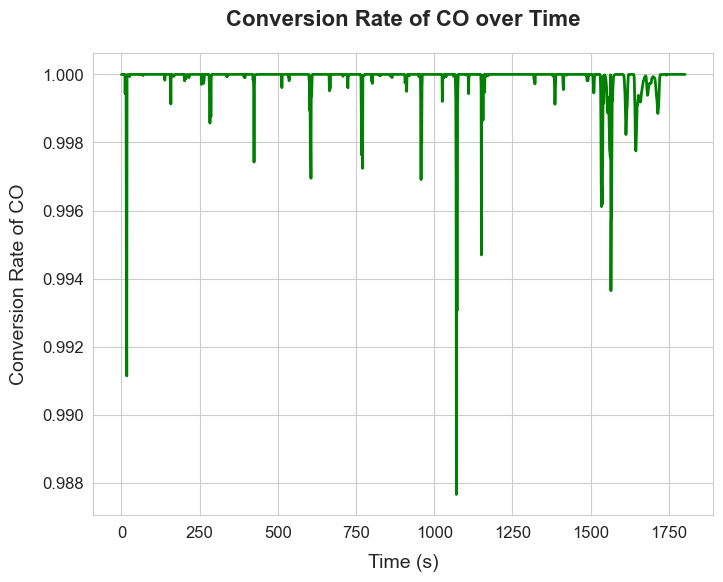

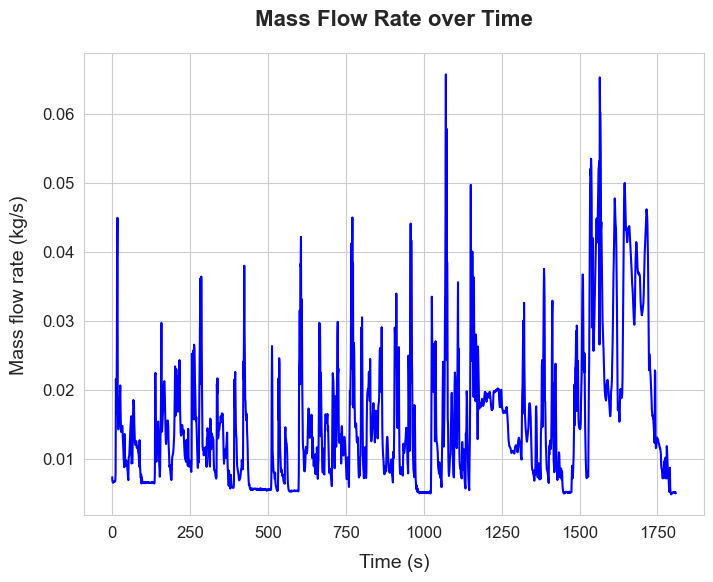

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Input of the problem
A = 1.8867e+11
delta_z = 0.005
T_zero = 300

# Read the data from excel
nedc = pd.read_excel('WLTC_input_data.xls')
time = nedc.iloc[:, 0].values
m_dot_total = nedc.iloc[:, 1].values
T_in = nedc.iloc[:, 2].values
O2_in = nedc.iloc[:, 3].values
CO_in = nedc.iloc[:, 4].values
n_nedc = nedc.shape[0]

## Geometry and working media characteristics

# Exhaust gas characteristics
M_gas = 29  # Molecular mass [kg/kmol]
# Oxidation catalyst materials
rho_s = 1500  # Density [kg/m3]
cp_s = 1000  # Heat capacity (p=cst) [J/(kg.K)]
kappa_s = 1.5  # Heat conductivity [W/(m.K)]
rho_wh = 1500  # Washcoat density [kg/m3]
# Oxidation catalyst geometrical characteristics
L = 70  # Catalyst length in mm
L = L * 1e-3  # [m]
D = 130  # Catalyst diameter in mm
D = D * 1e-3  # [m]
# Circular section
A_catalyst = np.pi / 4 * D ** 2  # Catalyst section [m2]
# Rectangular channels
cell_density = 400  # Cell density [cpsi]
cell_density = cell_density / (25.4 ** 2) * 1e6  # [cpsm]
nb_cells = A_catalyst * cell_density  # Total number of cells
wall_thickness = 6  # Wall thickness [mils]
wall_thickness = wall_thickness * 25.4 * 1e-6  # [m]
washcoat = 120  # Washcoat [g/l or kg/m3]
d_a = np.sqrt(1 / cell_density)  # Cell hydraulic diameter [m]
d_i = d_a - wall_thickness  # Channel diameter w/ washcoat [m]
void = (d_i / d_a) ** 2  # Void space ratio w/ washcoat [-]
void_wh = void - washcoat / rho_wh  # Void space ratio w/o washcoat [-]
d_h = d_a * np.sqrt(void_wh)  # Hydraulic diameter of channel w/o washcoat [m]
P = 4 * d_h  # Perimeter of channel w/o washcoat [m]
A_s = d_a ** 2 - d_h ** 2  # Surface of wall for conduction heat transfer

# Heat release of CO2 formation
DH_CO2 = -283 * 1e6  # CO+1/2*O2--> CO2 + DH[J/kmol CO]
# Reaction rate of CO on catalyst
E = 1e5  # Activation energy [J/mol]
R_u = 8.314  # Ideal gas constant [J/(mol.K)]

# Problem solution

# Space discretization
zeta = np.arange(0, L + delta_z, delta_z)
grid_space = zeta.size
delta_m_cat = rho_s * (delta_z * A_s)
# Time discretization
grid_time = time.size

# Assuming constant delta_t
if len(time) > 1:
    delta_t = time[1] - time[0]  # Time step [sec]
    time_steps = grid_time - 1  # Total time steps
else:
    delta_t = 0
    time_steps = 0

# Initial conditions & Boundary conditions
m_dot_channel = m_dot_total / nb_cells  # Flow through channel [kg/s]

# Initialize variables
T_g = np.ones((grid_time, grid_space)) * T_zero  # Gas temperature [K]
T_s = np.ones((grid_time, grid_space)) * T_zero  # Solid temperature [K]
q_conv_dot = np.zeros((grid_time, grid_space))  # Convection heat flux [W/(m2.K)]
q_exoth = np.zeros((grid_time, grid_space))
NTU_h = np.zeros((grid_time, grid_space))
NTU_m_CO = np.zeros((grid_time, grid_space))
c_s_CO = np.zeros((grid_time, grid_space))  # Surface concentration of CO [mol_CO/mol_total]
c_s_O2 = np.tile(O2_in, (grid_time, 1))  # Surface concentration of O2 [mol_O2/mol_total]
c_g_CO = np.zeros((grid_time, grid_space))  # Gas concentration of CO [mol_CO/mol_total]
c_g_O2 = np.tile(O2_in, (grid_time, 1))  # Gas concentration of O2 [mol_O2/mol_total]
T_g[:, 0] = T_in
c_g_CO[:, 0] = CO_in

# Solver
timestep = 0
for t in time:
    # Calculate the First node for every timestep(time)
    kappa_g = 2.02e-4 * T_g[timestep, 0] ** 0.837
    cp_g = 267 * T_g[timestep, 0] ** 0.226
    rho_g = 349.08 * T_g[timestep, 0] ** (-1.007)
    mhu_g = 0.355e-6 * T_g[timestep, 0] ** 0.679
    v = m_dot_channel[timestep] / rho_g / d_h ** 2
    Re = rho_g * v * d_h / mhu_g
    Pr = cp_g * mhu_g / kappa_g
    D_CO = 9.148e-10 * T_g[timestep, 0] ** 1.738
    Gz = 1 / (Re * Pr) * (delta_z / d_h)
    Nu = 2.976 * (1 + 0.095 / Gz) ** 0.45
    Sh = Nu
    h = Nu * kappa_g / d_h
    k_CO = Sh * D_CO / d_h
    NTU_h[timestep, 0] = (h * P * delta_z) / (m_dot_channel[timestep] * cp_g)
    NTU_m_CO[timestep, 0] = (P * delta_z) * k_CO * rho_g / m_dot_channel[timestep]
    coeff = k_CO * P * delta_z * rho_g / M_gas
    K = A * np.exp(-E / (R_u * T_s[timestep, 0]))

    # Boundary condition - adiabatic for t>0
    if timestep != 0:
        T_s[timestep, 0] = T_g[timestep, 0]
    
    c_s_CO[timestep, 0] = c_g_CO[timestep, 0] * coeff / (coeff + K * c_s_O2[timestep, 0])

    # Nodes 2 to end
    node = 1
    for z in zeta[1:]:
        # NTU calculations
        cp_g = 267 * T_g[timestep, node - 1] ** 0.226
        kappa_g = 2.02e-4 * T_g[timestep, node - 1] ** 0.837
        rho_g = 349.08 * T_g[timestep, node - 1] ** (-1.007)
        mhu_g = 0.355e-6 * T_g[timestep, node - 1] ** 0.679
        v = m_dot_channel[timestep] / rho_g / d_h ** 2
        Re = rho_g * v * d_h / mhu_g
        Pr = cp_g * mhu_g / kappa_g
        D_CO = 9.148e-10 * T_g[timestep, node - 1] ** 1.738
        Gz = 1 / (Re * Pr) * (z / d_h)
        Nu = 2.976 * (1 + 0.095 / Gz) ** 0.45
        Sh = Nu
        h = Nu * kappa_g / d_h
        k_CO = Sh * D_CO / d_h
        NTU_h[timestep, node] = (h * P * delta_z) / (m_dot_channel[timestep] * cp_g)
        NTU_m_CO[timestep, node] = (k_CO * P * delta_z) * rho_g / m_dot_channel[timestep]

        # T_s known a priori
        T_g[timestep, node] = T_s[timestep, node - 1] + (
                T_g[timestep, node - 1] - T_s[timestep, node - 1]) * np.exp(-NTU_h[timestep, node])

        c_g_CO[timestep, node] = c_s_CO[timestep, node - 1] + (
                c_g_CO[timestep, node - 1] - c_s_CO[timestep, node - 1]) * np.exp(-NTU_m_CO[timestep, node])

        coeff = k_CO * P * delta_z * rho_g / M_gas
        K = A * np.exp(-E / (R_u * T_g[timestep, node - 1]))
        c_s_CO[timestep, node] = c_g_CO[timestep, node] * coeff / (coeff + K * c_s_O2[timestep, node])
        R = coeff * (c_g_CO[timestep, node] - c_s_CO[timestep, node])
        q_exoth[timestep, node] = -R * DH_CO2
        q_exoth[timestep, 0] = q_exoth[timestep, 1]  # First boundary condition of inlet
        q_conv_dot[timestep, node] = h * (P * delta_z) * (T_g[timestep, node] - T_s[timestep, node])

        if timestep != len(time) - 1:
            if z != zeta[-1]:
                T_s[timestep + 1, node] = T_s[timestep, node] + delta_t / (delta_m_cat * cp_s) * (
                        q_exoth[timestep, node] + q_conv_dot[timestep, node] + kappa_s * A_s * (
                            T_s[timestep, node - 1] - T_s[timestep, node]) / delta_z - kappa_s * A_s * (
                                T_s[timestep, node] - T_s[timestep, node + 1]) / delta_z)
            else:
                # Last node
                T_s[timestep + 1, node] = T_s[timestep, node] + delta_t / (delta_m_cat * cp_s) * (
                        q_exoth[timestep, node] + q_conv_dot[timestep, node] + kappa_s * A_s * (
                            T_s[timestep, node - 1] - T_s[timestep, node]) / delta_z)
        node += 1

    timestep += 1

# Output
eta_CO = 1 - c_g_CO[:, -1] / CO_in
T_s_mean = np.mean(T_s, axis=1)
T_s_out = T_s[:, -1]
T_g_out = T_g[:, -1]
T_g_in = T_g[:, 0]

# Set the style
sns.set_style("whitegrid")

# Plot data
plt.figure(figsize=(8, 6))
plt.plot(time, T_g_out, linewidth=2, color='blue', label='Outlet Gas Temperature')
plt.plot(time, T_g_in, linewidth=1, color='red', alpha=0.7, linestyle='--', label='Inlet Gas Temperature')  # Adjusted opacity and line style
plt.xlabel('Time (s)', fontsize=14, labelpad=10)
plt.ylabel('Temperature (K)', fontsize=14, labelpad=10)
plt.title('Gas Temperature over Time', fontsize=16, pad=20, fontweight='bold')
plt.grid(True)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(fontsize=12)  # Add legend

# Save the figure
plt.savefig('exhaust_temp_time_plot.png', bbox_inches='tight')

# Create a new figure
plt.figure(figsize=(8, 6))
plt.plot(time, eta_CO, linewidth=2, color='green')
plt.xlabel('Time (s)', fontsize=14, labelpad=10)
plt.ylabel('Conversion Rate of CO', fontsize=14, labelpad=10)
plt.title('Conversion Rate of CO over Time', fontsize=16, pad=20, fontweight='bold')
plt.grid(True)
plt.tick_params(axis='both', which='major', labelsize=12)

# Save the figure
plt.savefig('conversion_rate_time_plot.png', bbox_inches='tight')

# Show the plots
plt.show()

# Create a new figure
plt.figure(figsize=(8, 6))
plt.plot(time, m_dot_total, linewidth=1.5, color='blue')
plt.xlabel('Time (s)', fontsize=14, labelpad=10)
plt.ylabel('Mass flow rate (kg/s)', fontsize=14, labelpad=10)
plt.title('Mass Flow Rate over Time', fontsize=16, pad=20, fontweight='bold')
plt.grid(True)
plt.tick_params(axis='both', which='major', labelsize=12)

# Save the figure
plt.savefig('gas_temp_mfr_plot.png', bbox_inches='tight')

# Show the plot
plt.show()
